### Monitoring of the water extent of Lake Neusiedl and the Lacken:
#### Train and Evaluation

In [1]:
# #
# import sys
# #
# from google.colab import drive
# #
# drive.mount('/content/drive')
# #
# sys.path.append('/content/drive/MyDrive/IntProject')

In [2]:

import sys

#
del sys.modules['data_func']
del sys.modules['utils']
# del sys.modules['model']


KeyError: 'data_func'

In [3]:
# pip install yeoda

In [4]:
# pip install tifftools

In [5]:
import torch
import copy
import numpy as np
from data_func import merge_files_and_split, ImageDataset, make_list, visualize_augmentations, \
    visualize_offline_augmentations
from model import DownSample, DoubleConv, OutConv, UpSample, UNet
from utils import *
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from torch import optim, nn
import cv2
import time
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torch.optim import Adam
from torch import permute
from torch import nan_to_num
from torch.nn import BCEWithLogitsLoss
from torchvision.transforms import ToTensor
import rasterio
from torch import nn
from torch import optim, nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
import os
from torch.nn import functional as F

os.environ["NO_ALBUMENTATIONS_UPDATE"] = "1"
import albumentations as A

from torch.cuda.amp import autocast, GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt
import warnings
import rasterio

warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
# pip install tqdm

In [7]:
# pip install torchvision

### Data Preparation & Augmentation

In [8]:
train_batch_size = 32
val_batch_size = 16
test_batch_size = 4

In [9]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
], )
test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ], )


In [18]:

run_colab = False
if run_colab:
    train_set = ImageDataset('./drive/MyDrive/IntProject/train/', './drive/MyDrive/IntProject/train_mask',
                             './drive/MyDrive/IntProject/train_mask_lacken',
                             train_transform)
    trainloader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=1)
    val_set = ImageDataset('./drive/MyDrive/IntProject/val/', './drive/MyDrive/IntProject/val_mask',
                           './drive/MyDrive/IntProject/val_mask_lacken',
                           train_transform)
    valloader = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, shuffle=True, num_workers=1)
    test_set = ImageDataset('./drive/MyDrive/IntProject/test/', './drive/MyDrive/IntProject/test_mask',
                            './drive/MyDrive/IntProject/test_mask_lacken', train_transform)
    testloader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, shuffle=True, num_workers=1)
    dict_file = './drive/MyDrive/IntProject/model_results3.txt'
    model_file = './drive/MyDrive/IntProject/model3.pt'
else:
    train_set = ImageDataset('./augmentations/train/', './augmentations/train_mask',
                             './augmentations/train_mask_lacken', train_transform)
    trainloader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=2)
    val_set = ImageDataset('./augmentations/val/', './augmentations/val_mask', './augmentations/val_mask_lacken',
                           train_transform)
    valloader = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, shuffle=True, num_workers=2)
    test_set = ImageDataset('./augmentations/test/', './augmentations/test_mask', './augmentations/test_mask_lacken',
                            train_transform)
    testloader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, shuffle=True, num_workers=2)
    dict_file = './model_results3.txt'
    model_file = './model3.pt'


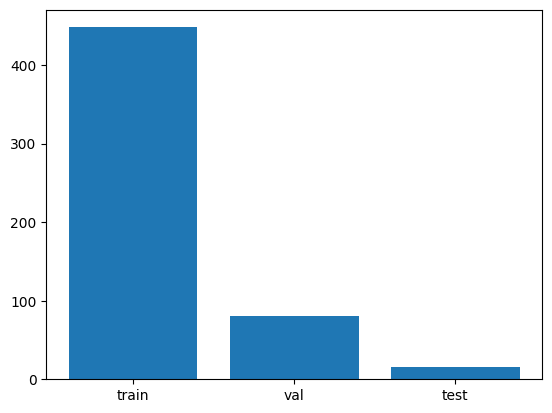

In [19]:
dataset_sizes = [len(train_set), len(val_set), len(test_set)]
labels = ['train', 'val', 'test']

plt.bar(labels, dataset_sizes)
plt.show()

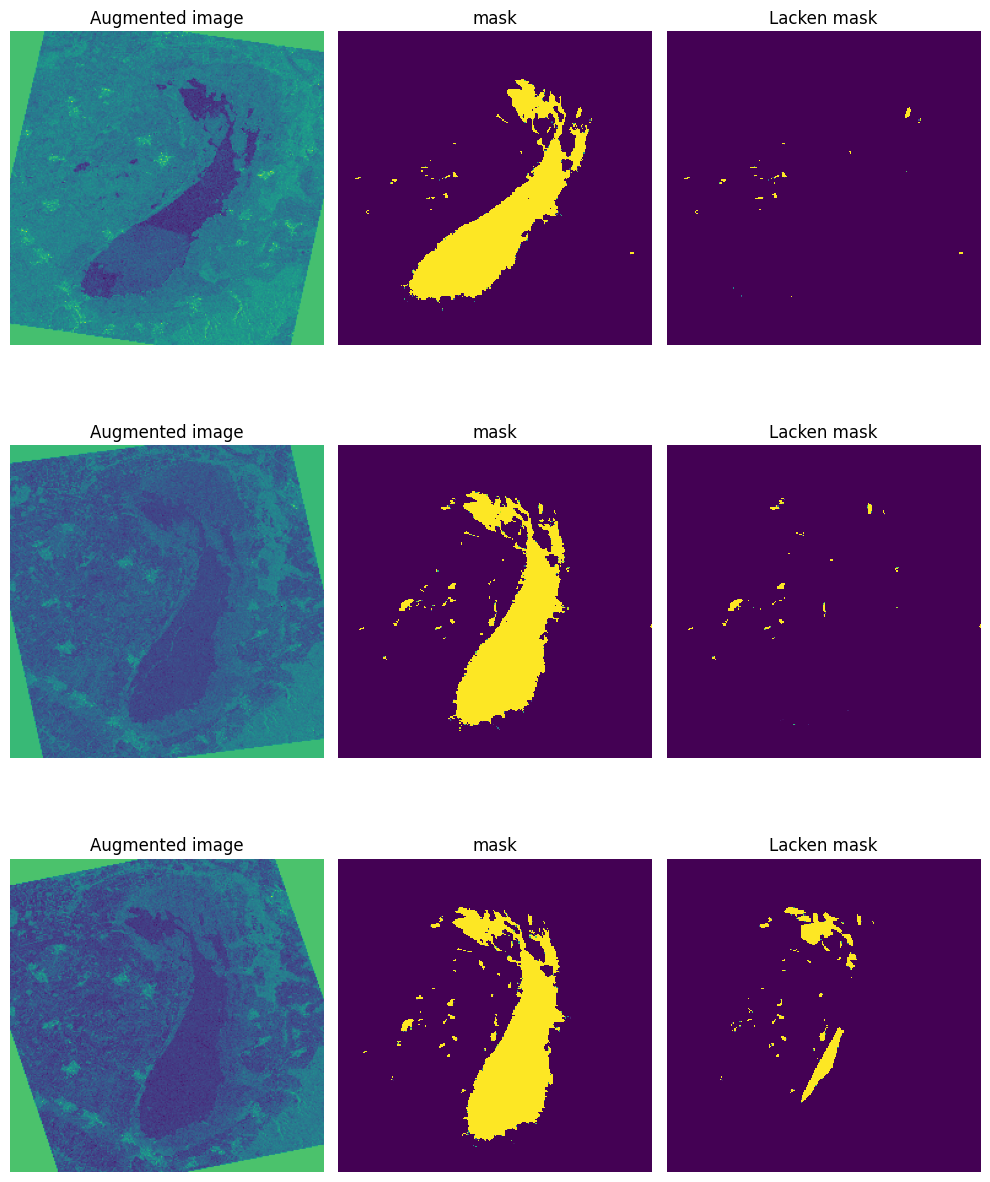

In [20]:
visualize_offline_augmentations(train_set, samples=3)


#### Train & Evaluate

In [21]:
epochs = 50
model = UNet(1, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
global_step = 0

In [22]:
train_evaluate(model, epochs, valloader, valloader, optimizer, criterion, dict_file,
               model_file, best_dice=0, patience=10)

  0%|          | 0/50 [00:00<?, ?it/s]/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The id

 
 Epoch: 1 
TRAIN FULL: Train Loss: 1.3287 | Train DICE Coeff: 0.4210  | Train IoU Coeff: 0.2246| | Train Bal Accuracy: 69.09 | Train Accuracy: 64.76 
TRAIN LACKENS: Train DICE Coeff: 0.0048  | Train IoU Coeff: 0.0030|  | Train Bal Accuracy: 55.71 |  Train Accuracy: 59.10 
VAL FULL: Val Loss: 2.0307 | Val DICE Coeff: 0.2110 | Val IoU Coeff: 0.1180 | Val Bal Accuracy: 50.00 | Val Accuracy: 11.69 
VAL LACKENS: Val DICE Coeff: 0.0045 | Val IoU Coeff: 0.0022 | Val Bal Accuracy: 50.00 |  Val Accuracy: 0.21| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 2 
TRAIN FULL: Train Loss: 1.0967 | Train DICE Coeff: 0.5702  | Train IoU Coeff: 0.3730| | Train Bal Accuracy: 81.18 | Train Accuracy: 83.93 
TRAIN LACKENS: Train DICE Coeff: 0.0048  | Train IoU Coeff: 0.0036|  | Train Bal Accuracy: 55.47 |  Train Accuracy: 77.56 
VAL FULL: Val Loss: 2.8075 | Val DICE Coeff: 0.2110 | Val IoU Coeff: 0.1180 | Val Bal Accuracy: 50.00 | Val Accuracy: 11.69 
VAL LACKENS: Val DICE Coeff: 0.0045 | Val IoU Coeff: 0.0022 | Val Bal Accuracy: 50.00 |  Val Accuracy: 0.21| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 3 
TRAIN FULL: Train Loss: 0.9814 | Train DICE Coeff: 0.5969  | Train IoU Coeff: 0.4335| | Train Bal Accuracy: 82.43 | Train Accuracy: 88.23 
TRAIN LACKENS: Train DICE Coeff: 0.0059  | Train IoU Coeff: 0.0032|  | Train Bal Accuracy: 52.87 |  Train Accuracy: 82.49 
VAL FULL: Val Loss: 3.9259 | Val DICE Coeff: 0.2120 | Val IoU Coeff: 0.1185 | Val Bal Accuracy: 50.24 | Val Accuracy: 12.19 
VAL LACKENS: Val DICE Coeff: 0.0045 | Val IoU Coeff: 0.0023 | Val Bal Accuracy: 50.28 |  Val Accuracy: 0.71| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 4 
TRAIN FULL: Train Loss: 0.8275 | Train DICE Coeff: 0.7716  | Train IoU Coeff: 0.6436| | Train Bal Accuracy: 88.32 | Train Accuracy: 94.27 
TRAIN LACKENS: Train DICE Coeff: 0.0013  | Train IoU Coeff: 0.0007|  | Train Bal Accuracy: 46.08 |  Train Accuracy: 87.13 
VAL FULL: Val Loss: 5.8956 | Val DICE Coeff: 0.2181 | Val IoU Coeff: 0.1223 | Val Bal Accuracy: 51.76 | Val Accuracy: 15.29 
VAL LACKENS: Val DICE Coeff: 0.0047 | Val IoU Coeff: 0.0023 | Val Bal Accuracy: 52.04 |  Val Accuracy: 3.81| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 5 
TRAIN FULL: Train Loss: 0.7363 | Train DICE Coeff: 0.8215  | Train IoU Coeff: 0.6926| | Train Bal Accuracy: 91.96 | Train Accuracy: 95.18 
TRAIN LACKENS: Train DICE Coeff: 0.0022  | Train IoU Coeff: 0.0012|  | Train Bal Accuracy: 47.07 |  Train Accuracy: 86.34 
VAL FULL: Val Loss: 10.1604 | Val DICE Coeff: 0.2179 | Val IoU Coeff: 0.1222 | Val Bal Accuracy: 51.75 | Val Accuracy: 15.18 
VAL LACKENS: Val DICE Coeff: 0.0047 | Val IoU Coeff: 0.0023 | Val Bal Accuracy: 51.98 |  Val Accuracy: 3.70| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 6 
TRAIN FULL: Train Loss: 0.7105 | Train DICE Coeff: 0.8081  | Train IoU Coeff: 0.6821| | Train Bal Accuracy: 90.71 | Train Accuracy: 95.17 
TRAIN LACKENS: Train DICE Coeff: 0.0018  | Train IoU Coeff: 0.0010|  | Train Bal Accuracy: 46.53 |  Train Accuracy: 87.00 
VAL FULL: Val Loss: 10.0525 | Val DICE Coeff: 0.2342 | Val IoU Coeff: 0.1317 | Val Bal Accuracy: 55.00 | Val Accuracy: 22.13 
VAL LACKENS: Val DICE Coeff: 0.0051 | Val IoU Coeff: 0.0025 | Val Bal Accuracy: 55.92 |  Val Accuracy: 10.65| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 7 
TRAIN FULL: Train Loss: 0.6657 | Train DICE Coeff: 0.8154  | Train IoU Coeff: 0.7060| | Train Bal Accuracy: 89.77 | Train Accuracy: 95.89 
TRAIN LACKENS: Train DICE Coeff: 0.0020  | Train IoU Coeff: 0.0011|  | Train Bal Accuracy: 47.30 |  Train Accuracy: 88.45 
VAL FULL: Val Loss: 15.7947 | Val DICE Coeff: 0.2354 | Val IoU Coeff: 0.1330 | Val Bal Accuracy: 54.96 | Val Accuracy: 23.01 
VAL LACKENS: Val DICE Coeff: 0.0050 | Val IoU Coeff: 0.0025 | Val Bal Accuracy: 56.41 |  Val Accuracy: 11.53| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 8 
TRAIN FULL: Train Loss: 0.6166 | Train DICE Coeff: 0.8320  | Train IoU Coeff: 0.7096| | Train Bal Accuracy: 91.66 | Train Accuracy: 95.72 
TRAIN LACKENS: Train DICE Coeff: 0.0045  | Train IoU Coeff: 0.0023|  | Train Bal Accuracy: 50.24 |  Train Accuracy: 87.23 
VAL FULL: Val Loss: 2.3673 | Val DICE Coeff: 0.3475 | Val IoU Coeff: 0.2093 | Val Bal Accuracy: 62.00 | Val Accuracy: 55.57 
VAL LACKENS: Val DICE Coeff: 0.0063 | Val IoU Coeff: 0.0032 | Val Bal Accuracy: 74.67 |  Val Accuracy: 44.14| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 9 
TRAIN FULL: Train Loss: 0.5738 | Train DICE Coeff: 0.8438  | Train IoU Coeff: 0.7444| | Train Bal Accuracy: 91.05 | Train Accuracy: 96.49 
TRAIN LACKENS: Train DICE Coeff: 0.0019  | Train IoU Coeff: 0.0009|  | Train Bal Accuracy: 46.89 |  Train Accuracy: 88.54 
VAL FULL: Val Loss: 2.1304 | Val DICE Coeff: 0.3263 | Val IoU Coeff: 0.2081 | Val Bal Accuracy: 54.12 | Val Accuracy: 67.45 
VAL LACKENS: Val DICE Coeff: 0.0049 | Val IoU Coeff: 0.0027 | Val Bal Accuracy: 69.53 |  Val Accuracy: 62.33| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 10 
TRAIN FULL: Train Loss: 0.5126 | Train DICE Coeff: 0.8748  | Train IoU Coeff: 0.7803| | Train Bal Accuracy: 92.73 | Train Accuracy: 97.00 
TRAIN LACKENS: Train DICE Coeff: 0.0021  | Train IoU Coeff: 0.0010|  | Train Bal Accuracy: 47.01 |  Train Accuracy: 88.30 
VAL FULL: Val Loss: 1.3884 | Val DICE Coeff: 0.2241 | Val IoU Coeff: 0.2174 | Val Bal Accuracy: 57.42 | Val Accuracy: 79.06 
VAL LACKENS: Val DICE Coeff: 0.0083 | Val IoU Coeff: 0.0038 | Val Bal Accuracy: 66.20 |  Val Accuracy: 79.29| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 11 
TRAIN FULL: Train Loss: 0.4634 | Train DICE Coeff: 0.8887  | Train IoU Coeff: 0.7975| | Train Bal Accuracy: 93.96 | Train Accuracy: 97.21 
TRAIN LACKENS: Train DICE Coeff: 0.0008  | Train IoU Coeff: 0.0004|  | Train Bal Accuracy: 44.97 |  Train Accuracy: 87.88 
VAL FULL: Val Loss: 1.0347 | Val DICE Coeff: 0.2921 | Val IoU Coeff: 0.2222 | Val Bal Accuracy: 53.25 | Val Accuracy: 89.87 
VAL LACKENS: Val DICE Coeff: 0.0101 | Val IoU Coeff: 0.0053 | Val Bal Accuracy: 61.72 |  Val Accuracy: 95.78| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 12 
TRAIN FULL: Train Loss: 0.4149 | Train DICE Coeff: 0.9105  | Train IoU Coeff: 0.8366| | Train Bal Accuracy: 94.19 | Train Accuracy: 97.85 
TRAIN LACKENS: Train DICE Coeff: 0.0004  | Train IoU Coeff: 0.0001|  | Train Bal Accuracy: 44.69 |  Train Accuracy: 88.60 
VAL FULL: Val Loss: 0.7115 | Val DICE Coeff: 0.6904 | Val IoU Coeff: 0.4856 | Val Bal Accuracy: 56.48 | Val Accuracy: 89.25 
VAL LACKENS: Val DICE Coeff: 0.0050 | Val IoU Coeff: 0.0037 | Val Bal Accuracy: 87.10 |  Val Accuracy: 81.30| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 13 
TRAIN FULL: Train Loss: 0.3763 | Train DICE Coeff: 0.9171  | Train IoU Coeff: 0.8464| | Train Bal Accuracy: 95.30 | Train Accuracy: 97.94 
TRAIN LACKENS: Train DICE Coeff: 0.0011  | Train IoU Coeff: 0.0005|  | Train Bal Accuracy: 45.50 |  Train Accuracy: 88.12 
VAL FULL: Val Loss: 0.5815 | Val DICE Coeff: 0.7547 | Val IoU Coeff: 0.6517 | Val Bal Accuracy: 47.39 | Val Accuracy: 95.66 
VAL LACKENS: Val DICE Coeff: 0.0017 | Val IoU Coeff: 0.0007 | Val Bal Accuracy: 83.62 |  Val Accuracy: 91.48| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 14 
TRAIN FULL: Train Loss: 0.3700 | Train DICE Coeff: 0.9075  | Train IoU Coeff: 0.8315| | Train Bal Accuracy: 94.32 | Train Accuracy: 97.76 
TRAIN LACKENS: Train DICE Coeff: 0.0015  | Train IoU Coeff: 0.0007|  | Train Bal Accuracy: 46.29 |  Train Accuracy: 88.43 
VAL FULL: Val Loss: 0.5356 | Val DICE Coeff: 0.7997 | Val IoU Coeff: 0.6862 | Val Bal Accuracy: 48.77 | Val Accuracy: 95.94 
VAL LACKENS: Val DICE Coeff: 0.0033 | Val IoU Coeff: 0.0016 | Val Bal Accuracy: 86.49 |  Val Accuracy: 90.30| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 15 
TRAIN FULL: Train Loss: 0.3577 | Train DICE Coeff: 0.8999  | Train IoU Coeff: 0.8218| | Train Bal Accuracy: 94.61 | Train Accuracy: 97.56 
TRAIN LACKENS: Train DICE Coeff: 0.0021  | Train IoU Coeff: 0.0010|  | Train Bal Accuracy: 47.06 |  Train Accuracy: 88.00 
VAL FULL: Val Loss: 3.6548 | Val DICE Coeff: 0.4216 | Val IoU Coeff: 0.2127 | Val Bal Accuracy: 51.44 | Val Accuracy: 56.65 
VAL LACKENS: Val DICE Coeff: 0.0042 | Val IoU Coeff: 0.0024 | Val Bal Accuracy: 74.69 |  Val Accuracy: 45.46| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 16 
TRAIN FULL: Train Loss: 0.3169 | Train DICE Coeff: 0.9154  | Train IoU Coeff: 0.8427| | Train Bal Accuracy: 95.06 | Train Accuracy: 97.89 
TRAIN LACKENS: Train DICE Coeff: 0.0025  | Train IoU Coeff: 0.0012|  | Train Bal Accuracy: 47.73 |  Train Accuracy: 88.20 
VAL FULL: Val Loss: 0.4171 | Val DICE Coeff: 0.8604 | Val IoU Coeff: 0.7597 | Val Bal Accuracy: 49.64 | Val Accuracy: 96.60 
VAL LACKENS: Val DICE Coeff: 0.0038 | Val IoU Coeff: 0.0020 | Val Bal Accuracy: 93.36 |  Val Accuracy: 87.43| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 17 
TRAIN FULL: Train Loss: 0.3213 | Train DICE Coeff: 0.9029  | Train IoU Coeff: 0.8237| | Train Bal Accuracy: 95.11 | Train Accuracy: 97.54 
TRAIN LACKENS: Train DICE Coeff: 0.0036  | Train IoU Coeff: 0.0018|  | Train Bal Accuracy: 49.10 |  Train Accuracy: 87.73 
VAL FULL: Val Loss: 4.3849 | Val DICE Coeff: 0.4589 | Val IoU Coeff: 0.2198 | Val Bal Accuracy: 52.93 | Val Accuracy: 57.84 
VAL LACKENS: Val DICE Coeff: 0.0046 | Val IoU Coeff: 0.0025 | Val Bal Accuracy: 75.53 |  Val Accuracy: 46.57| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 18 
TRAIN FULL: Train Loss: 0.2697 | Train DICE Coeff: 0.9290  | Train IoU Coeff: 0.8675| | Train Bal Accuracy: 94.98 | Train Accuracy: 98.27 
TRAIN LACKENS: Train DICE Coeff: 0.0014  | Train IoU Coeff: 0.0007|  | Train Bal Accuracy: 46.33 |  Train Accuracy: 88.75 
VAL FULL: Val Loss: 1.1337 | Val DICE Coeff: 0.6678 | Val IoU Coeff: 0.4237 | Val Bal Accuracy: 58.62 | Val Accuracy: 83.77 
VAL LACKENS: Val DICE Coeff: 0.0060 | Val IoU Coeff: 0.0036 | Val Bal Accuracy: 89.90 |  Val Accuracy: 72.64| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 19 
TRAIN FULL: Train Loss: 0.2426 | Train DICE Coeff: 0.9356  | Train IoU Coeff: 0.8788| | Train Bal Accuracy: 96.42 | Train Accuracy: 98.38 
TRAIN LACKENS: Train DICE Coeff: 0.0026  | Train IoU Coeff: 0.0013|  | Train Bal Accuracy: 47.69 |  Train Accuracy: 88.10 
VAL FULL: Val Loss: 2.4629 | Val DICE Coeff: 0.6024 | Val IoU Coeff: 0.2808 | Val Bal Accuracy: 53.72 | Val Accuracy: 69.19 
VAL LACKENS: Val DICE Coeff: 0.0035 | Val IoU Coeff: 0.0026 | Val Bal Accuracy: 80.46 |  Val Accuracy: 58.73| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 20 
TRAIN FULL: Train Loss: 0.2279 | Train DICE Coeff: 0.9399  | Train IoU Coeff: 0.8869| | Train Bal Accuracy: 96.29 | Train Accuracy: 98.50 
TRAIN LACKENS: Train DICE Coeff: 0.0033  | Train IoU Coeff: 0.0016|  | Train Bal Accuracy: 48.64 |  Train Accuracy: 88.34 
VAL FULL: Val Loss: 1.4961 | Val DICE Coeff: 0.6343 | Val IoU Coeff: 0.3145 | Val Bal Accuracy: 56.20 | Val Accuracy: 74.71 
VAL LACKENS: Val DICE Coeff: 0.0044 | Val IoU Coeff: 0.0030 | Val Bal Accuracy: 83.69 |  Val Accuracy: 64.20| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 21 
TRAIN FULL: Train Loss: 0.2089 | Train DICE Coeff: 0.9435  | Train IoU Coeff: 0.8928| | Train Bal Accuracy: 96.60 | Train Accuracy: 98.57 
TRAIN LACKENS: Train DICE Coeff: 0.0043  | Train IoU Coeff: 0.0021|  | Train Bal Accuracy: 49.97 |  Train Accuracy: 88.28 
VAL FULL: Val Loss: 0.3014 | Val DICE Coeff: 0.8979 | Val IoU Coeff: 0.8110 | Val Bal Accuracy: 50.96 | Val Accuracy: 97.37 
VAL LACKENS: Val DICE Coeff: 0.0045 | Val IoU Coeff: 0.0025 | Val Bal Accuracy: 95.01 |  Val Accuracy: 87.58| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 22 
TRAIN FULL: Train Loss: 0.2015 | Train DICE Coeff: 0.9423  | Train IoU Coeff: 0.8908| | Train Bal Accuracy: 96.61 | Train Accuracy: 98.54 
TRAIN LACKENS: Train DICE Coeff: 0.0044  | Train IoU Coeff: 0.0021|  | Train Bal Accuracy: 50.21 |  Train Accuracy: 88.24 
VAL FULL: Val Loss: 0.3473 | Val DICE Coeff: 0.8643 | Val IoU Coeff: 0.7680 | Val Bal Accuracy: 52.26 | Val Accuracy: 97.04 
VAL LACKENS: Val DICE Coeff: 0.0064 | Val IoU Coeff: 0.0031 | Val Bal Accuracy: 90.07 |  Val Accuracy: 89.84| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 23 
TRAIN FULL: Train Loss: 0.1898 | Train DICE Coeff: 0.9452  | Train IoU Coeff: 0.8962| | Train Bal Accuracy: 96.56 | Train Accuracy: 98.62 
TRAIN LACKENS: Train DICE Coeff: 0.0049  | Train IoU Coeff: 0.0024|  | Train Bal Accuracy: 50.82 |  Train Accuracy: 88.38 
VAL FULL: Val Loss: 0.3216 | Val DICE Coeff: 0.8728 | Val IoU Coeff: 0.7718 | Val Bal Accuracy: 52.91 | Val Accuracy: 96.84 
VAL LACKENS: Val DICE Coeff: 0.0054 | Val IoU Coeff: 0.0031 | Val Bal Accuracy: 93.12 |  Val Accuracy: 87.94| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 24 
TRAIN FULL: Train Loss: 0.1799 | Train DICE Coeff: 0.9463  | Train IoU Coeff: 0.8980| | Train Bal Accuracy: 96.89 | Train Accuracy: 98.64 
TRAIN LACKENS: Train DICE Coeff: 0.0051  | Train IoU Coeff: 0.0025|  | Train Bal Accuracy: 51.16 |  Train Accuracy: 88.21 
VAL FULL: Val Loss: 0.4537 | Val DICE Coeff: 0.8011 | Val IoU Coeff: 0.6370 | Val Bal Accuracy: 54.85 | Val Accuracy: 93.52 
VAL LACKENS: Val DICE Coeff: 0.0062 | Val IoU Coeff: 0.0034 | Val Bal Accuracy: 94.21 |  Val Accuracy: 83.01| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 25 
TRAIN FULL: Train Loss: 0.1647 | Train DICE Coeff: 0.9505  | Train IoU Coeff: 0.9055| | Train Bal Accuracy: 96.82 | Train Accuracy: 98.74 
TRAIN LACKENS: Train DICE Coeff: 0.0049  | Train IoU Coeff: 0.0024|  | Train Bal Accuracy: 50.91 |  Train Accuracy: 88.39 
VAL FULL: Val Loss: 0.5539 | Val DICE Coeff: 0.6820 | Val IoU Coeff: 0.5556 | Val Bal Accuracy: 51.66 | Val Accuracy: 94.60 
VAL LACKENS: Val DICE Coeff: 0.0104 | Val IoU Coeff: 0.0032 | Val Bal Accuracy: 78.20 |  Val Accuracy: 93.05| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 26 
TRAIN FULL: Train Loss: 0.1564 | Train DICE Coeff: 0.9517  | Train IoU Coeff: 0.9078| | Train Bal Accuracy: 97.18 | Train Accuracy: 98.76 
TRAIN LACKENS: Train DICE Coeff: 0.0054  | Train IoU Coeff: 0.0026|  | Train Bal Accuracy: 51.52 |  Train Accuracy: 88.22 
VAL FULL: Val Loss: 0.2243 | Val DICE Coeff: 0.9165 | Val IoU Coeff: 0.8521 | Val Bal Accuracy: 50.10 | Val Accuracy: 98.12 
VAL LACKENS: Val DICE Coeff: 0.0045 | Val IoU Coeff: 0.0021 | Val Bal Accuracy: 93.43 |  Val Accuracy: 89.43| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 27 
TRAIN FULL: Train Loss: 0.1543 | Train DICE Coeff: 0.9509  | Train IoU Coeff: 0.9064| | Train Bal Accuracy: 96.89 | Train Accuracy: 98.75 
TRAIN LACKENS: Train DICE Coeff: 0.0055  | Train IoU Coeff: 0.0027|  | Train Bal Accuracy: 51.76 |  Train Accuracy: 88.38 
VAL FULL: Val Loss: 0.1845 | Val DICE Coeff: 0.9361 | Val IoU Coeff: 0.8816 | Val Bal Accuracy: 50.04 | Val Accuracy: 98.47 
VAL LACKENS: Val DICE Coeff: 0.0040 | Val IoU Coeff: 0.0020 | Val Bal Accuracy: 95.05 |  Val Accuracy: 89.00| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 28 
TRAIN FULL: Train Loss: 0.1512 | Train DICE Coeff: 0.9497  | Train IoU Coeff: 0.9040| | Train Bal Accuracy: 97.01 | Train Accuracy: 98.72 
TRAIN LACKENS: Train DICE Coeff: 0.0050  | Train IoU Coeff: 0.0025|  | Train Bal Accuracy: 51.33 |  Train Accuracy: 88.25 
VAL FULL: Val Loss: 0.2653 | Val DICE Coeff: 0.8845 | Val IoU Coeff: 0.7917 | Val Bal Accuracy: 48.66 | Val Accuracy: 97.12 
VAL LACKENS: Val DICE Coeff: 0.0033 | Val IoU Coeff: 0.0017 | Val Bal Accuracy: 94.07 |  Val Accuracy: 87.77| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 29 
TRAIN FULL: Train Loss: 0.1486 | Train DICE Coeff: 0.9485  | Train IoU Coeff: 0.9024| | Train Bal Accuracy: 96.81 | Train Accuracy: 98.70 
TRAIN LACKENS: Train DICE Coeff: 0.0060  | Train IoU Coeff: 0.0029|  | Train Bal Accuracy: 52.29 |  Train Accuracy: 88.35 
VAL FULL: Val Loss: 0.2208 | Val DICE Coeff: 0.9089 | Val IoU Coeff: 0.8328 | Val Bal Accuracy: 48.48 | Val Accuracy: 97.83 
VAL LACKENS: Val DICE Coeff: 0.0031 | Val IoU Coeff: 0.0015 | Val Bal Accuracy: 93.61 |  Val Accuracy: 88.96| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 30 
TRAIN FULL: Train Loss: 0.1428 | Train DICE Coeff: 0.9506  | Train IoU Coeff: 0.9060| | Train Bal Accuracy: 96.86 | Train Accuracy: 98.75 
TRAIN LACKENS: Train DICE Coeff: 0.0059  | Train IoU Coeff: 0.0029|  | Train Bal Accuracy: 52.54 |  Train Accuracy: 88.38 
VAL FULL: Val Loss: 0.8210 | Val DICE Coeff: 0.6517 | Val IoU Coeff: 0.4637 | Val Bal Accuracy: 57.49 | Val Accuracy: 86.97 
VAL LACKENS: Val DICE Coeff: 0.0066 | Val IoU Coeff: 0.0036 | Val Bal Accuracy: 90.20 |  Val Accuracy: 76.69| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 31 
TRAIN FULL: Train Loss: 0.1342 | Train DICE Coeff: 0.9528  | Train IoU Coeff: 0.9098| | Train Bal Accuracy: 97.16 | Train Accuracy: 98.79 
TRAIN LACKENS: Train DICE Coeff: 0.0050  | Train IoU Coeff: 0.0024|  | Train Bal Accuracy: 51.01 |  Train Accuracy: 88.26 
VAL FULL: Val Loss: 0.2646 | Val DICE Coeff: 0.8759 | Val IoU Coeff: 0.7662 | Val Bal Accuracy: 52.51 | Val Accuracy: 96.50 
VAL LACKENS: Val DICE Coeff: 0.0055 | Val IoU Coeff: 0.0029 | Val Bal Accuracy: 95.68 |  Val Accuracy: 86.10| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 32 
TRAIN FULL: Train Loss: 0.1373 | Train DICE Coeff: 0.9507  | Train IoU Coeff: 0.9058| | Train Bal Accuracy: 97.08 | Train Accuracy: 98.73 
TRAIN LACKENS: Train DICE Coeff: 0.0058  | Train IoU Coeff: 0.0028|  | Train Bal Accuracy: 52.05 |  Train Accuracy: 88.24 
VAL FULL: Val Loss: 0.4443 | Val DICE Coeff: 0.7853 | Val IoU Coeff: 0.6413 | Val Bal Accuracy: 54.09 | Val Accuracy: 93.72 
VAL LACKENS: Val DICE Coeff: 0.0066 | Val IoU Coeff: 0.0033 | Val Bal Accuracy: 93.92 |  Val Accuracy: 83.45| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 33 
TRAIN FULL: Train Loss: 0.1354 | Train DICE Coeff: 0.9504  | Train IoU Coeff: 0.9054| | Train Bal Accuracy: 96.74 | Train Accuracy: 98.74 
TRAIN LACKENS: Train DICE Coeff: 0.0044  | Train IoU Coeff: 0.0021|  | Train Bal Accuracy: 50.04 |  Train Accuracy: 88.43 
VAL FULL: Val Loss: 0.5944 | Val DICE Coeff: 0.7348 | Val IoU Coeff: 0.5672 | Val Bal Accuracy: 52.73 | Val Accuracy: 91.75 
VAL LACKENS: Val DICE Coeff: 0.0055 | Val IoU Coeff: 0.0029 | Val Bal Accuracy: 91.45 |  Val Accuracy: 82.20| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 34 
TRAIN FULL: Train Loss: 0.1291 | Train DICE Coeff: 0.9520  | Train IoU Coeff: 0.9083| | Train Bal Accuracy: 97.18 | Train Accuracy: 98.77 
TRAIN LACKENS: Train DICE Coeff: 0.0045  | Train IoU Coeff: 0.0022|  | Train Bal Accuracy: 50.29 |  Train Accuracy: 88.22 
VAL FULL: Val Loss: 0.2785 | Val DICE Coeff: 0.8594 | Val IoU Coeff: 0.7659 | Val Bal Accuracy: 50.33 | Val Accuracy: 97.10 
VAL LACKENS: Val DICE Coeff: 0.0050 | Val IoU Coeff: 0.0023 | Val Bal Accuracy: 88.96 |  Val Accuracy: 90.51| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 35 
TRAIN FULL: Train Loss: 0.1251 | Train DICE Coeff: 0.9536  | Train IoU Coeff: 0.9111| | Train Bal Accuracy: 97.06 | Train Accuracy: 98.81 
TRAIN LACKENS: Train DICE Coeff: 0.0058  | Train IoU Coeff: 0.0029|  | Train Bal Accuracy: 52.44 |  Train Accuracy: 88.36 
VAL FULL: Val Loss: 1.0120 | Val DICE Coeff: 0.3229 | Val IoU Coeff: 0.2260 | Val Bal Accuracy: 52.98 | Val Accuracy: 90.68 
VAL LACKENS: Val DICE Coeff: 0.0114 | Val IoU Coeff: 0.0062 | Val Bal Accuracy: 61.41 |  Val Accuracy: 97.00| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 36 
TRAIN FULL: Train Loss: 0.1219 | Train DICE Coeff: 0.9541  | Train IoU Coeff: 0.9122| | Train Bal Accuracy: 97.17 | Train Accuracy: 98.82 
TRAIN LACKENS: Train DICE Coeff: 0.0056  | Train IoU Coeff: 0.0027|  | Train Bal Accuracy: 51.94 |  Train Accuracy: 88.31 
VAL FULL: Val Loss: 0.3779 | Val DICE Coeff: 0.7938 | Val IoU Coeff: 0.7336 | Val Bal Accuracy: 49.88 | Val Accuracy: 96.71 
VAL LACKENS: Val DICE Coeff: 0.0059 | Val IoU Coeff: 0.0020 | Val Bal Accuracy: 87.36 |  Val Accuracy: 90.84| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 37 
TRAIN FULL: Train Loss: 0.1173 | Train DICE Coeff: 0.9553  | Train IoU Coeff: 0.9143| | Train Bal Accuracy: 97.15 | Train Accuracy: 98.85 
TRAIN LACKENS: Train DICE Coeff: 0.0050  | Train IoU Coeff: 0.0024|  | Train Bal Accuracy: 50.93 |  Train Accuracy: 88.35 
VAL FULL: Val Loss: 0.2300 | Val DICE Coeff: 0.8854 | Val IoU Coeff: 0.8178 | Val Bal Accuracy: 50.06 | Val Accuracy: 97.72 
VAL LACKENS: Val DICE Coeff: 0.0049 | Val IoU Coeff: 0.0020 | Val Bal Accuracy: 91.57 |  Val Accuracy: 89.91| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 38 
TRAIN FULL: Train Loss: 0.1133 | Train DICE Coeff: 0.9563  | Train IoU Coeff: 0.9162| | Train Bal Accuracy: 97.41 | Train Accuracy: 98.87 
TRAIN LACKENS: Train DICE Coeff: 0.0062  | Train IoU Coeff: 0.0030|  | Train Bal Accuracy: 52.60 |  Train Accuracy: 88.25 
VAL FULL: Val Loss: 0.2869 | Val DICE Coeff: 0.8500 | Val IoU Coeff: 0.7821 | Val Bal Accuracy: 51.00 | Val Accuracy: 97.28 
VAL LACKENS: Val DICE Coeff: 0.0064 | Val IoU Coeff: 0.0025 | Val Bal Accuracy: 89.93 |  Val Accuracy: 90.21| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 39 
TRAIN FULL: Train Loss: 0.1203 | Train DICE Coeff: 0.9529  | Train IoU Coeff: 0.9099| | Train Bal Accuracy: 96.87 | Train Accuracy: 98.80 
TRAIN LACKENS: Train DICE Coeff: 0.0055  | Train IoU Coeff: 0.0027|  | Train Bal Accuracy: 51.67 |  Train Accuracy: 88.45 
VAL FULL: Val Loss: 0.4584 | Val DICE Coeff: 0.7431 | Val IoU Coeff: 0.6653 | Val Bal Accuracy: 51.26 | Val Accuracy: 95.87 
VAL LACKENS: Val DICE Coeff: 0.0096 | Val IoU Coeff: 0.0028 | Val Bal Accuracy: 83.97 |  Val Accuracy: 91.59| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 40 
TRAIN FULL: Train Loss: 0.1211 | Train DICE Coeff: 0.9506  | Train IoU Coeff: 0.9058| | Train Bal Accuracy: 97.20 | Train Accuracy: 98.73 
TRAIN LACKENS: Train DICE Coeff: 0.0054  | Train IoU Coeff: 0.0027|  | Train Bal Accuracy: 51.69 |  Train Accuracy: 88.17 
VAL FULL: Val Loss: 0.9147 | Val DICE Coeff: 0.4131 | Val IoU Coeff: 0.3159 | Val Bal Accuracy: 56.82 | Val Accuracy: 91.41 
VAL LACKENS: Val DICE Coeff: 0.0162 | Val IoU Coeff: 0.0083 | Val Bal Accuracy: 66.32 |  Val Accuracy: 95.31| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 41 
TRAIN FULL: Train Loss: 0.1137 | Train DICE Coeff: 0.9541  | Train IoU Coeff: 0.9122| | Train Bal Accuracy: 96.98 | Train Accuracy: 98.83 
TRAIN LACKENS: Train DICE Coeff: 0.0045  | Train IoU Coeff: 0.0022|  | Train Bal Accuracy: 50.42 |  Train Accuracy: 88.42 
VAL FULL: Val Loss: 0.4643 | Val DICE Coeff: 0.7934 | Val IoU Coeff: 0.6424 | Val Bal Accuracy: 53.78 | Val Accuracy: 93.73 
VAL LACKENS: Val DICE Coeff: 0.0062 | Val IoU Coeff: 0.0032 | Val Bal Accuracy: 94.05 |  Val Accuracy: 83.38| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 42 
TRAIN FULL: Train Loss: 0.1102 | Train DICE Coeff: 0.9557  | Train IoU Coeff: 0.9151| | Train Bal Accuracy: 97.29 | Train Accuracy: 98.86 
TRAIN LACKENS: Train DICE Coeff: 0.0059  | Train IoU Coeff: 0.0029|  | Train Bal Accuracy: 52.38 |  Train Accuracy: 88.29 
VAL FULL: Val Loss: 0.7284 | Val DICE Coeff: 0.5360 | Val IoU Coeff: 0.4263 | Val Bal Accuracy: 61.75 | Val Accuracy: 92.50 
VAL LACKENS: Val DICE Coeff: 0.0161 | Val IoU Coeff: 0.0095 | Val Bal Accuracy: 72.80 |  Val Accuracy: 93.28| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 43 
TRAIN FULL: Train Loss: 0.1077 | Train DICE Coeff: 0.9565  | Train IoU Coeff: 0.9165| | Train Bal Accuracy: 97.19 | Train Accuracy: 98.88 
TRAIN LACKENS: Train DICE Coeff: 0.0055  | Train IoU Coeff: 0.0027|  | Train Bal Accuracy: 51.73 |  Train Accuracy: 88.38 
VAL FULL: Val Loss: 0.3023 | Val DICE Coeff: 0.8457 | Val IoU Coeff: 0.7458 | Val Bal Accuracy: 53.80 | Val Accuracy: 96.76 
VAL LACKENS: Val DICE Coeff: 0.0076 | Val IoU Coeff: 0.0036 | Val Bal Accuracy: 88.96 |  Val Accuracy: 90.06| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 44 
TRAIN FULL: Train Loss: 0.1048 | Train DICE Coeff: 0.9570  | Train IoU Coeff: 0.9174| | Train Bal Accuracy: 97.46 | Train Accuracy: 98.89 
TRAIN LACKENS: Train DICE Coeff: 0.0053  | Train IoU Coeff: 0.0026|  | Train Bal Accuracy: 51.52 |  Train Accuracy: 88.23 
VAL FULL: Val Loss: 0.3964 | Val DICE Coeff: 0.7850 | Val IoU Coeff: 0.7036 | Val Bal Accuracy: 49.64 | Val Accuracy: 96.35 
VAL LACKENS: Val DICE Coeff: 0.0066 | Val IoU Coeff: 0.0019 | Val Bal Accuracy: 85.81 |  Val Accuracy: 91.21| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 45 
TRAIN FULL: Train Loss: 0.1024 | Train DICE Coeff: 0.9582  | Train IoU Coeff: 0.9197| | Train Bal Accuracy: 97.29 | Train Accuracy: 98.92 
TRAIN LACKENS: Train DICE Coeff: 0.0056  | Train IoU Coeff: 0.0027|  | Train Bal Accuracy: 51.86 |  Train Accuracy: 88.37 
VAL FULL: Val Loss: 0.1075 | Val DICE Coeff: 0.9555 | Val IoU Coeff: 0.9147 | Val Bal Accuracy: 49.52 | Val Accuracy: 98.87 
VAL LACKENS: Val DICE Coeff: 0.0037 | Val IoU Coeff: 0.0018 | Val Bal Accuracy: 96.83 |  Val Accuracy: 88.55| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 46 
TRAIN FULL: Train Loss: 0.1116 | Train DICE Coeff: 0.9530  | Train IoU Coeff: 0.9101| | Train Bal Accuracy: 97.16 | Train Accuracy: 98.79 
TRAIN LACKENS: Train DICE Coeff: 0.0057  | Train IoU Coeff: 0.0028|  | Train Bal Accuracy: 51.99 |  Train Accuracy: 88.28 
VAL FULL: Val Loss: 0.1778 | Val DICE Coeff: 0.9208 | Val IoU Coeff: 0.8505 | Val Bal Accuracy: 49.92 | Val Accuracy: 97.99 
VAL LACKENS: Val DICE Coeff: 0.0043 | Val IoU Coeff: 0.0021 | Val Bal Accuracy: 95.52 |  Val Accuracy: 88.13| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 47 
TRAIN FULL: Train Loss: 0.1103 | Train DICE Coeff: 0.9532  | Train IoU Coeff: 0.9105| | Train Bal Accuracy: 97.06 | Train Accuracy: 98.80 
TRAIN LACKENS: Train DICE Coeff: 0.0044  | Train IoU Coeff: 0.0022|  | Train Bal Accuracy: 50.26 |  Train Accuracy: 88.33 
VAL FULL: Val Loss: 0.2625 | Val DICE Coeff: 0.8749 | Val IoU Coeff: 0.7687 | Val Bal Accuracy: 55.01 | Val Accuracy: 96.49 
VAL LACKENS: Val DICE Coeff: 0.0069 | Val IoU Coeff: 0.0037 | Val Bal Accuracy: 96.28 |  Val Accuracy: 85.77| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 48 
TRAIN FULL: Train Loss: 0.1240 | Train DICE Coeff: 0.9452  | Train IoU Coeff: 0.8967| | Train Bal Accuracy: 96.51 | Train Accuracy: 98.63 
TRAIN LACKENS: Train DICE Coeff: 0.0052  | Train IoU Coeff: 0.0026|  | Train Bal Accuracy: 51.39 |  Train Accuracy: 88.41 
VAL FULL: Val Loss: 0.5341 | Val DICE Coeff: 0.7039 | Val IoU Coeff: 0.5797 | Val Bal Accuracy: 58.06 | Val Accuracy: 93.78 
VAL LACKENS: Val DICE Coeff: 0.0153 | Val IoU Coeff: 0.0051 | Val Bal Accuracy: 84.35 |  Val Accuracy: 88.67| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 49 
TRAIN FULL: Train Loss: 0.1318 | Train DICE Coeff: 0.9410  | Train IoU Coeff: 0.8892| | Train Bal Accuracy: 96.35 | Train Accuracy: 98.53 
TRAIN LACKENS: Train DICE Coeff: 0.0056  | Train IoU Coeff: 0.0028|  | Train Bal Accuracy: 51.85 |  Train Accuracy: 88.37 
VAL FULL: Val Loss: 0.9684 | Val DICE Coeff: 0.4403 | Val IoU Coeff: 0.3907 | Val Bal Accuracy: 51.67 | Val Accuracy: 90.98 
VAL LACKENS: Val DICE Coeff: 0.0039 | Val IoU Coeff: 0.0030 | Val Bal Accuracy: 72.93 |  Val Accuracy: 91.17| 


/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

 
 Epoch: 50 
TRAIN FULL: Train Loss: 0.1296 | Train DICE Coeff: 0.9415  | Train IoU Coeff: 0.8895| | Train Bal Accuracy: 96.17 | Train Accuracy: 98.54 
TRAIN LACKENS: Train DICE Coeff: 0.0039  | Train IoU Coeff: 0.0019|  | Train Bal Accuracy: 49.61 |  Train Accuracy: 88.47 
VAL FULL: Val Loss: 3.4595 | Val DICE Coeff: 0.3858 | Val IoU Coeff: 0.2294 | Val Bal Accuracy: 60.30 | Val Accuracy: 61.01 
VAL LACKENS: Val DICE Coeff: 0.0069 | Val IoU Coeff: 0.0032 | Val Bal Accuracy: 77.14 |  Val Accuracy: 49.90| 



#### Evaluating on Test Data

In [23]:
model = UNet(1,1)
state_dict = torch.load(model_file)  # Load the state_dict
model.load_state_dict(state_dict)  # Load weights into the model
model = model.to(device)

/var/folders/kj/50p9jhyx70135t3lmjp58l9h0000gn/T/ipykernel_18630/2905527223.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_file)  # Load t

Dice Coefficient: 0.9571835994720459
Dice Coefficient Lackens: 0.006489523686468601


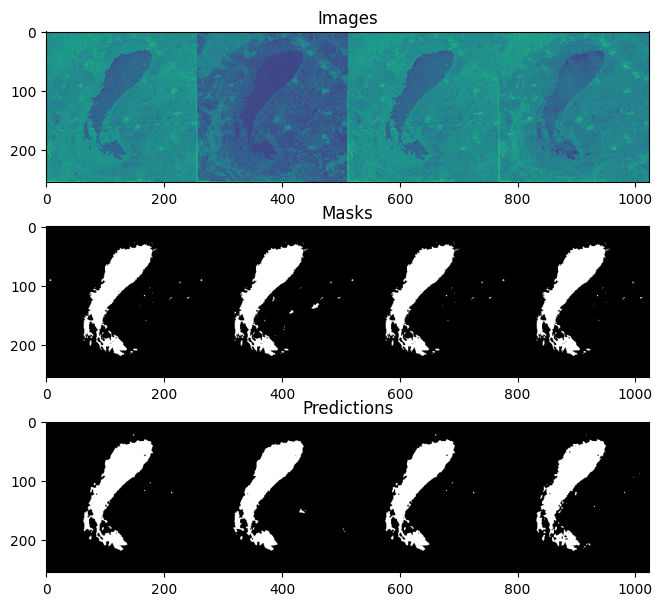

Dice Coefficient: 0.9532020092010498
Dice Coefficient Lackens: 0.005732635036110878


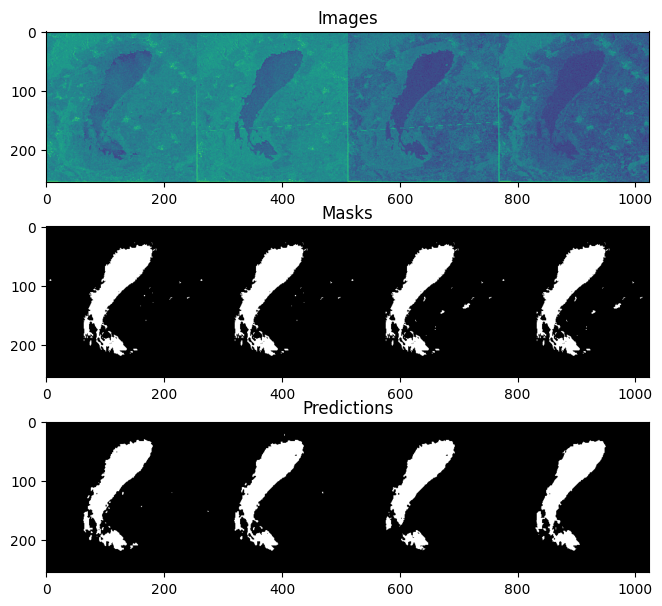

Dice Coefficient: 0.9491007924079895
Dice Coefficient Lackens: 0.007840522564947605


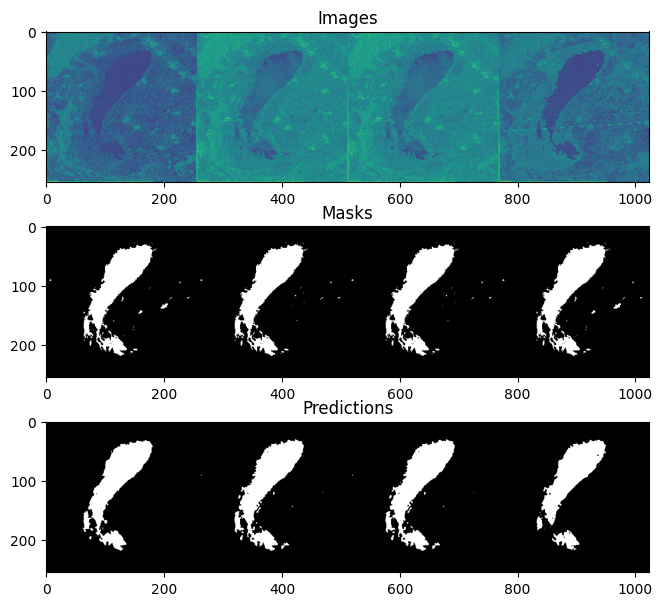

Dice Coefficient: 0.9522899389266968
Dice Coefficient Lackens: 0.0036778368521481752


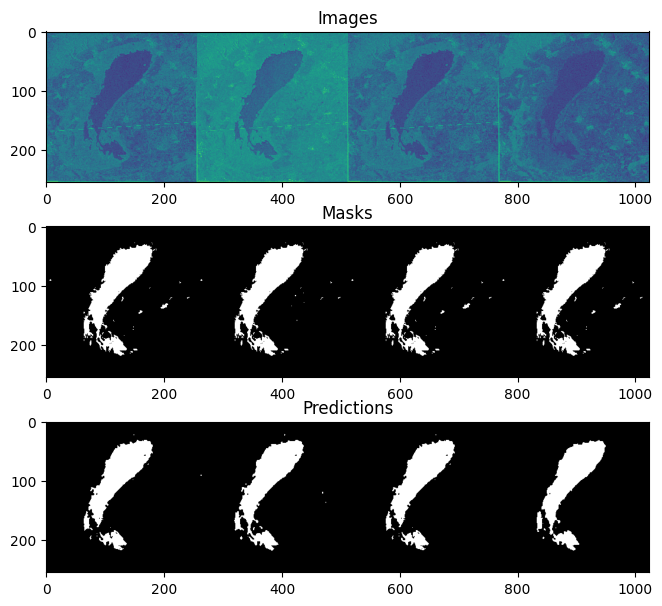

/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  data

In [24]:
def display_batch(images, masks, pred, lacken_masks):
    print(f"Dice Coefficient: {dice_coeff(pred.to(device), masks.to(device))}")
    print(f"Dice Coefficient Lackens: {dice_coeff(pred.to(device), lacken_masks.to(device))}")

    images = images.permute(0, 2, 3, 1)
    masks = masks.permute(0, 2, 3, 1)
    pred = pred.permute(0, 2, 3, 1)

    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    pred = pred.cpu().numpy()

    images = np.concatenate(images, axis=1)
    masks = np.concatenate(masks, axis=1)
    pred = np.concatenate(pred, axis=1)

    fig, ax = plt.subplots(3, 1, figsize=(20, 6))
    fig.tight_layout()
    ax[0].imshow(images)
    ax[0].set_title('Images')
    ax[1].imshow(masks, cmap='gray')
    ax[1].set_title('Masks')
    ax[2].imshow(pred, cmap='gray')
    ax[2].set_title('Predictions')

    plt.show()


for images, masks, lacken_masks in testloader:
    with torch.no_grad():
        pred = model(images.to(device)).detach()
        pred = (pred > 0.5).float()

    display_batch(images, masks, pred, lacken_masks)
